In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from os import listdir

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

### Load datasets

In [3]:
df1 = pd.read_csv('dataset_fbm_target_0.csv',header=None)
df2 = pd.read_csv('dataset_fbm_target_1.csv', header=None)

In [4]:
df1.head(5)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.0,0.054653,0.132473,0.166179,0.219223,0.166224,0.223717,0.234737,0.181752,0.240739,...,-0.860267,-0.906902,-0.829231,-0.811425,-0.750427,-0.651314,-0.695100,-0.638686,-0.786556,0.0
1,0.0,0.096685,0.053403,0.072431,0.120024,0.142002,0.209432,0.240277,0.321979,0.395410,...,0.749411,0.613989,0.451497,0.525397,0.525881,0.496032,0.500053,0.587889,0.443416,0.0
2,0.0,-0.024728,-0.043989,-0.091526,-0.205577,-0.266951,-0.318029,-0.298911,-0.297087,-0.448494,...,-1.684643,-1.621030,-1.662795,-1.644794,-1.643079,-1.649599,-1.705844,-1.693458,-1.741250,0.0
3,0.0,0.053649,-0.013770,0.122753,0.094493,0.022394,0.106990,0.152904,0.149246,0.239737,...,1.229833,1.227078,1.187702,1.069809,1.103109,1.053878,1.058083,0.997871,0.844252,0.0
4,0.0,0.036753,-0.039029,0.028088,0.089706,0.120707,0.146665,0.019556,-0.025031,-0.126672,...,0.423407,0.490730,0.498146,0.506943,0.541367,0.497067,0.625605,0.628363,0.660385,0.0


In [3]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

### Join datasets to one dataframe

In [6]:
df = df1.append(df2)
df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.0,0.054653,0.132473,0.166179,0.219223,0.166224,0.223717,0.234737,0.181752,0.240739,...,-0.860267,-0.906902,-0.829231,-0.811425,-0.750427,-0.651314,-0.695100,-0.638686,-0.786556,0.0
1,0.0,0.096685,0.053403,0.072431,0.120024,0.142002,0.209432,0.240277,0.321979,0.395410,...,0.749411,0.613989,0.451497,0.525397,0.525881,0.496032,0.500053,0.587889,0.443416,0.0
2,0.0,-0.024728,-0.043989,-0.091526,-0.205577,-0.266951,-0.318029,-0.298911,-0.297087,-0.448494,...,-1.684643,-1.621030,-1.662795,-1.644794,-1.643079,-1.649599,-1.705844,-1.693458,-1.741250,0.0
3,0.0,0.053649,-0.013770,0.122753,0.094493,0.022394,0.106990,0.152904,0.149246,0.239737,...,1.229833,1.227078,1.187702,1.069809,1.103109,1.053878,1.058083,0.997871,0.844252,0.0
4,0.0,0.036753,-0.039029,0.028088,0.089706,0.120707,0.146665,0.019556,-0.025031,-0.126672,...,0.423407,0.490730,0.498146,0.506943,0.541367,0.497067,0.625605,0.628363,0.660385,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.0,-0.028713,-0.045893,-0.056188,-0.072219,-0.096426,-0.124043,-0.126961,-0.138749,-0.150061,...,-1.863159,-1.880961,-1.897656,-1.903383,-1.889623,-1.907247,-1.929271,-1.954850,-1.956546,1.0
496,0.0,0.017111,0.041465,0.054576,0.077498,0.099334,0.108366,0.115584,0.121283,0.128573,...,0.834131,0.807836,0.789682,0.775336,0.764918,0.755541,0.751312,0.749309,0.746875,1.0
497,0.0,0.011208,0.025415,0.027544,0.020891,0.031642,0.031130,0.039696,0.069318,0.086062,...,0.412687,0.410566,0.414043,0.409309,0.400862,0.395507,0.402936,0.412333,0.425467,1.0
498,0.0,0.008682,-0.001444,-0.004643,-0.017820,-0.026764,-0.036294,-0.049927,-0.055700,-0.067074,...,-1.230183,-1.239901,-1.255810,-1.241760,-1.247697,-1.257556,-1.265583,-1.272530,-1.278749,1.0


#### Save targets to у variable

In [7]:
y = df[199]

In [8]:
df.drop(columns=[199], inplace=True)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,189,190,191,192,193,194,195,196,197,198
0,0.0,0.054653,0.132473,0.166179,0.219223,0.166224,0.223717,0.234737,0.181752,0.240739,...,-0.871151,-0.860267,-0.906902,-0.829231,-0.811425,-0.750427,-0.651314,-0.695100,-0.638686,-0.786556
1,0.0,0.096685,0.053403,0.072431,0.120024,0.142002,0.209432,0.240277,0.321979,0.395410,...,0.728597,0.749411,0.613989,0.451497,0.525397,0.525881,0.496032,0.500053,0.587889,0.443416
2,0.0,-0.024728,-0.043989,-0.091526,-0.205577,-0.266951,-0.318029,-0.298911,-0.297087,-0.448494,...,-1.708459,-1.684643,-1.621030,-1.662795,-1.644794,-1.643079,-1.649599,-1.705844,-1.693458,-1.741250
3,0.0,0.053649,-0.013770,0.122753,0.094493,0.022394,0.106990,0.152904,0.149246,0.239737,...,1.150194,1.229833,1.227078,1.187702,1.069809,1.103109,1.053878,1.058083,0.997871,0.844252
4,0.0,0.036753,-0.039029,0.028088,0.089706,0.120707,0.146665,0.019556,-0.025031,-0.126672,...,0.381790,0.423407,0.490730,0.498146,0.506943,0.541367,0.497067,0.625605,0.628363,0.660385


In [9]:
X_train, X_val, y_train, y_val = train_test_split(df, y, test_size=0.33, random_state=42)

In [10]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((670, 199), (330, 199), (670,), (330,))

In [11]:
X_train = np.expand_dims(X_train, axis=2)
X_train.shape

(670, 199, 1)

In [12]:
X_val = np.expand_dims(X_val, axis=2)
X_val.shape

(330, 199, 1)

### Model

In [13]:
model = Sequential()
model.add(LSTM(256, input_shape=(199, 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dense(1, activation='sigmoid'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 199, 256)          264192    
_________________________________________________________________
dropout (Dropout)            (None, 199, 256)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 199, 64)           82176     
_________________________________________________________________
dense (Dense)                (None, 199, 1)            65        
Total params: 346,433
Trainable params: 346,433
Non-trainable params: 0
_________________________________________________________________


In [15]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((670, 199, 1), (670,), (330, 199, 1), (330,))

### Training

In [16]:
n_epochs = 75

In [17]:
adam = Adam(lr=0.001)
#chk = ModelCheckpoint('best_model_pkl', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.fit(X_train, y_train, epochs=n_epochs, batch_size=128, validation_data=(X_val,y_val))

Epoch 1/100
6/6 [==============================] - 4s 192ms/step - loss: 0.6934 - accuracy: 0.5344 - val_loss: 0.6953 - val_accuracy: 0.5141
Epoch 2/100
6/6 [==============================] - 0s 49ms/step - loss: 0.6902 - accuracy: 0.5484 - val_loss: 0.6957 - val_accuracy: 0.5035
Epoch 3/100
6/6 [==============================] - 0s 48ms/step - loss: 0.6895 - accuracy: 0.5180 - val_loss: 0.6966 - val_accuracy: 0.5144
Epoch 4/100
6/6 [==============================] - 0s 50ms/step - loss: 0.6873 - accuracy: 0.5310 - val_loss: 0.6935 - val_accuracy: 0.5489
Epoch 5/100
6/6 [==============================] - 0s 50ms/step - loss: 0.6915 - accuracy: 0.5323 - val_loss: 0.6921 - val_accuracy: 0.5294
Epoch 6/100
6/6 [==============================] - 0s 49ms/step - loss: 0.6902 - accuracy: 0.5402 - val_loss: 0.6966 - val_accuracy: 0.5146
Epoch 7/100
6/6 [==============================] - 0s 49ms/step - loss: 0.6875 - accuracy: 0.5467 - val_loss: 0.7006 - val_accuracy: 0.5143
Epoch 8/100
6/6 [==

### Some graphics of training/validation curves

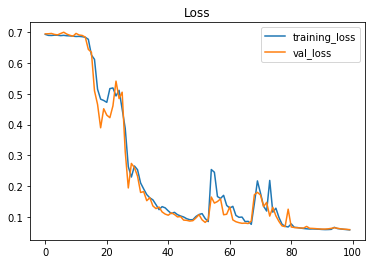

In [18]:
plt.figure()
plt.plot(np.arange(n_epochs),model.history.history['loss'],  label='training_loss')
plt.plot(np.arange(n_epochs),model.history.history['val_loss'],  label='val_loss')
plt.legend()
plt.title('Loss')
plt.show()

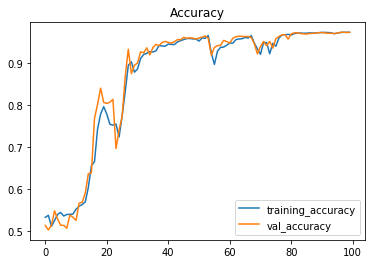

In [19]:
plt.figure()
plt.plot(np.arange(n_epochs),model.history.history['accuracy'],  label='training_accuracy')
plt.plot(np.arange(n_epochs),model.history.history['val_accuracy'],  label='val_accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

### PART 2 Multiclassification problem (diffusion, subdiffusion, superdiffusion)

In [4]:
df_1 = pd.read_csv('dataset_fbm_target_diff.csv',header=None)
df_2 = pd.read_csv('dataset_fbm_target_supdiff.csv', header=None)
df_3 = pd.read_csv('dataset_fbm_target_subdiff.csv', header=None)

In [5]:
df_1.head(5)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.0,0.082510,0.086568,0.255690,0.383855,0.337089,0.376000,0.397869,0.514333,0.352712,...,1.285643,1.274488,1.496116,1.471009,1.553893,1.507774,1.601450,1.574640,1.837744,0.0
1,0.0,0.003041,-0.005935,-0.051895,0.074328,-0.087612,-0.038786,-0.023029,0.032464,0.132751,...,-0.136516,-0.182775,-0.160557,-0.131670,-0.179929,-0.218621,-0.120250,-0.200790,-0.160362,0.0
2,0.0,-0.019594,-0.165254,-0.006617,-0.147199,-0.170065,-0.205338,-0.389645,-0.567495,-0.316423,...,0.100821,0.097799,0.188756,0.158453,0.237068,0.149605,0.174923,0.130132,0.094157,0.0
3,0.0,-0.074867,-0.111489,-0.085473,-0.264691,-0.216136,-0.150480,-0.099763,-0.154332,-0.015472,...,0.129153,0.174248,0.061091,0.084727,0.090232,0.076863,0.185706,0.134054,-0.066915,0.0
4,0.0,-0.085939,-0.087235,-0.015803,0.098593,0.379073,0.364475,0.345635,0.349535,0.298660,...,0.084711,0.165619,0.238479,0.314082,0.353113,0.280368,0.436145,0.429452,0.262821,0.0


In [6]:
df_ = df_2.append(df_3)
df_ = df_1.append(df_)
df_.head(5)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.0,0.082510,0.086568,0.255690,0.383855,0.337089,0.376000,0.397869,0.514333,0.352712,...,1.285643,1.274488,1.496116,1.471009,1.553893,1.507774,1.601450,1.574640,1.837744,0.0
1,0.0,0.003041,-0.005935,-0.051895,0.074328,-0.087612,-0.038786,-0.023029,0.032464,0.132751,...,-0.136516,-0.182775,-0.160557,-0.131670,-0.179929,-0.218621,-0.120250,-0.200790,-0.160362,0.0
2,0.0,-0.019594,-0.165254,-0.006617,-0.147199,-0.170065,-0.205338,-0.389645,-0.567495,-0.316423,...,0.100821,0.097799,0.188756,0.158453,0.237068,0.149605,0.174923,0.130132,0.094157,0.0
3,0.0,-0.074867,-0.111489,-0.085473,-0.264691,-0.216136,-0.150480,-0.099763,-0.154332,-0.015472,...,0.129153,0.174248,0.061091,0.084727,0.090232,0.076863,0.185706,0.134054,-0.066915,0.0
4,0.0,-0.085939,-0.087235,-0.015803,0.098593,0.379073,0.364475,0.345635,0.349535,0.298660,...,0.084711,0.165619,0.238479,0.314082,0.353113,0.280368,0.436145,0.429452,0.262821,0.0


In [7]:
y_ = df_[99]
df_.drop(columns=[99], inplace=True)
df_.head()

,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
0,0.0,0.082510,0.086568,0.255690,0.383855,0.337089,0.376000,0.397869,0.514333,0.352712,...,1.387027,1.285643,1.274488,1.496116,1.471009,1.553893,1.507774,1.601450,1.574640,1.837744
1,0.0,0.003041,-0.005935,-0.051895,0.074328,-0.087612,-0.038786,-0.023029,0.032464,0.132751,...,-0.073086,-0.136516,-0.182775,-0.160557,-0.131670,-0.179929,-0.218621,-0.120250,-0.200790,-0.160362
2,0.0,-0.019594,-0.165254,-0.006617,-0.147199,-0.170065,-0.205338,-0.389645,-0.567495,-0.316423,...,-0.095642,0.100821,0.097799,0.188756,0.158453,0.237068,0.149605,0.174923,0.130132,0.094157
3,0.0,-0.074867,-0.111489,-0.085473,-0.264691,-0.216136,-0.150480,-0.099763,-0.154332,-0.015472,...,-0.043998,0.129153,0.174248,0.061091,0.084727,0.090232,0.076863,0.185706,0.134054,-0.066915
4,0.0,-0.085939,-0.087235,-0.015803,0.098593,0.379073,0.364475,0.345635,0.349535,0.298660,...,0.078549,0.084711,0.165619,0.238479,0.314082,0.353113,0.280368,0.436145,0.429452,0.262821


In [8]:
Xtrain, Xval, ytrain, yval = train_test_split(df_, y_, test_size=0.25, random_state=42)

In [9]:
Xtrain.shape, Xval.shape, ytrain.shape, yval.shape

((2250, 99), (750, 99), (2250,), (750,))

In [10]:
Xtrain = np.expand_dims(Xtrain, axis=2)
Xval = np.expand_dims(Xval, axis=2)
Xtrain.shape, Xval.shape

((2250, 99, 1), (750, 99, 1))

In [11]:
NUM_CLASSES = 3

In [12]:
ytrain = tf.one_hot(ytrain, NUM_CLASSES)
yval = tf.one_hot(yval, NUM_CLASSES)

### Model

In [33]:
from tensorflow.keras.layers import Flatten
from tensorflow.keras.activations import tanh

In [36]:
model2 = Sequential()
model2.add(LSTM(64, input_shape=(99, 1), return_sequences=True, activation=tanh))
#model2.add(Dropout(0.2))
#model2.add(LSTM(64, return_sequences=True, activation=tanh))
model2.add(Flatten())
model2.add(Dense(3, activation='softmax'))

In [37]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 99, 64)            16896     
_________________________________________________________________
flatten_3 (Flatten)          (None, 6336)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 19011     
Total params: 35,907
Trainable params: 35,907
Non-trainable params: 0
_________________________________________________________________


## Training

In [38]:
adam = Adam(lr=0.001)
#chk = ModelCheckpoint('best_model_pkl', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
model2.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
#model.fit(Xtrain, ytrain, epochs=n_epochs, batch_size=128, validation_data=(X_val,y_val))
model2.fit(Xtrain, ytrain, epochs=n_epochs, batch_size=64, validation_data=(Xval,yval))

Epoch 1/100
36/36 [==============================] - 1s 14ms/step - loss: 1.1116 - accuracy: 0.3559 - val_loss: 1.0552 - val_accuracy: 0.4813
Epoch 2/100
36/36 [==============================] - 0s 7ms/step - loss: 1.0128 - accuracy: 0.4859 - val_loss: 0.9425 - val_accuracy: 0.5227
Epoch 3/100
36/36 [==============================] - 0s 7ms/step - loss: 0.9154 - accuracy: 0.5430 - val_loss: 0.8544 - val_accuracy: 0.5747
Epoch 4/100
36/36 [==============================] - 0s 7ms/step - loss: 0.8628 - accuracy: 0.5789 - val_loss: 0.7333 - val_accuracy: 0.6200
Epoch 5/100
36/36 [==============================] - 0s 7ms/step - loss: 0.6337 - accuracy: 0.6933 - val_loss: 0.4376 - val_accuracy: 0.7973
Epoch 6/100
36/36 [==============================] - 0s 7ms/step - loss: 0.4454 - accuracy: 0.8178 - val_loss: 0.3910 - val_accuracy: 0.8240
Epoch 7/100
36/36 [==============================] - 0s 7ms/step - loss: 0.3357 - accuracy: 0.8609 - val_loss: 0.5282 - val_accuracy: 0.8267
Epoch 8/100


Epoch 59/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0027 - accuracy: 0.9997 - val_loss: 0.0285 - val_accuracy: 0.9933
Epoch 60/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0054 - accuracy: 0.9990 - val_loss: 0.0362 - val_accuracy: 0.9893
Epoch 61/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0118 - accuracy: 0.9945 - val_loss: 0.0223 - val_accuracy: 0.9960
Epoch 62/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0039 - accuracy: 0.9989 - val_loss: 0.0367 - val_accuracy: 0.9893
Epoch 63/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0312 - accuracy: 0.9883 - val_loss: 0.1090 - val_accuracy: 0.9587
Epoch 64/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0342 - accuracy: 0.9933 - val_loss: 0.0413 - val_accuracy: 0.9853
Epoch 65/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0079 - accuracy: 0.9990 - val_loss: 0.0322 - val_accuracy: 0.9920
Epoch 

### Some graphics of results

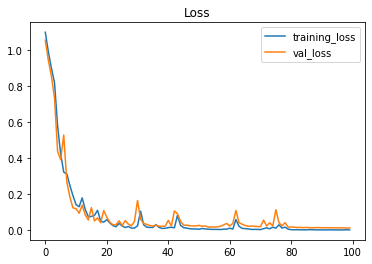

In [39]:
plt.figure()
plt.plot(np.arange(n_epochs),model2.history.history['loss'],  label='training_loss')
plt.plot(np.arange(n_epochs),model2.history.history['val_loss'],  label='val_loss')
plt.legend()
plt.title('Loss')
plt.show()

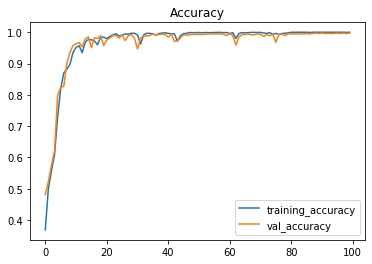

In [40]:
plt.figure()
plt.plot(np.arange(n_epochs),model2.history.history['accuracy'],  label='training_accuracy')
plt.plot(np.arange(n_epochs),model2.history.history['val_accuracy'],  label='val_accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

### Traditional methods of ML (random forest, gb)

##### Random forest

In [13]:
from sklearn.ensemble import RandomForestClassifier

In [14]:
from sklearn.metrics import accuracy_score

In [15]:
X_train = np.squeeze(X_train)
X_val = np.squeeze(X_val)
X_train.shape, X_val.shape

NameError: name 'X_train' is not defined

In [25]:
rf = RandomForestClassifier(n_estimators=100, n_jobs = -1)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_val)
print(accuracy_score(y_pred, y_val))

0.9727272727272728


#### Part 2.1 multiclassification

In [27]:
ydecode = tf.argmax(ytrain, axis=1).numpy()
yvaldecode = tf.argmax(yval, axis=1).numpy()

In [28]:
rf2 = RandomForestClassifier(n_estimators=150, n_jobs=-1)

In [29]:
Xtrain = np.squeeze(Xtrain)
Xval = np.squeeze(Xval)
Xtrain.shape, Xval.shape

((2250, 99), (750, 99))

In [34]:
rf2.fit(Xtrain, ydecode)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [35]:
ydecode.shape

(2250,)

In [41]:
cv = KFold(n_splits=5, shuffle=True, random_state = 42)
params_rf = {
    'max_depth': range(5, 15, 2),
    'n_estimators':[50, 100, 120, 140, 160, 180, 200, 300]
}
gs_rf = GridSearchCV(rf2, param_grid=params_rf, cv=cv, n_jobs=-1)
gs_rf.fit(Xtrain, ydecode)
gs_rf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=13, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [43]:
ypred = gs_rf.best_estimator_.predict(Xval)

In [45]:
accuracy_score(ypred, yvaldecode)

0.9133333333333333

##### Gradient boosting

In [46]:
from xgboost import XGBClassifier

In [47]:
xgbclf = XGBClassifier(n_estimators=100, n_jobs=-1, use_label_encoder=False)
xgbclf.fit(X_train, y_train)
y_pred = xgbclf.predict(X_val)
accuracy_score(y_pred, y_val)

NameError: name 'X_train' is not defined

In [48]:
# 0.94

In [49]:
xgbclf2 = XGBClassifier(n_estimators=100, n_jobs=-1, use_label_encoder=False)
xgbclf2.fit(Xtrain, ydecode)

[14:55:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [50]:
ypred = xgbclf2.predict(Xval)

In [51]:
count = 0
for i in range(ypred.shape[0]):
    if ypred[i] == yvaldecode[i]:
        count += 1
count / ypred.shape[0]

0.92

In [53]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
params_xg = {
    'n_estimators':range(50, 200, 20),
    'max_depth':range(5,15,2),
}
gs_xg = GridSearchCV(xgbclf2, param_grid=params_xg, cv=cv, n_jobs=-1)
gs_xg.fit(Xtrain, ydecode)
gs_xg.best_estimator_

[14:59:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=110, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [54]:
ypred = gs_xg.best_estimator_.predict(Xval)
accuracy_score(ypred, yvaldecode)

0.9266666666666666